# AD07 - 113M observações japonesas de `customs` (1988 - 2020)

CSV data for Japan's 100 million customs trade statistics since 1988 until 2020

https://www.kaggle.com/datasets/zanjibar/100-million-data-csv?datasetId=684488

- Coluna 0: ym(Year + month),
- Coluna 1: exp_imp(export: 1, import: 2),
- Coluna 2: hs9(HS code),
- Coluna 3: Customs,
- Coluna 4: Country,
- Coluna 5: Q1,
- Coluna 6: Q2(quantity),
- Coluna 7: Value(in thousands of yen)

In [ ]:
import numpy as np
import dask.array as da

## Obter os dados

### Opção #1

A primeira opção envolve baixar o arquivo `zip` original a partir do link kaggle acima, obtendo o arquivo `custom_1988_2020.csv` para em seguida separá-lo por ano com o script abaixo.


In [ ]:
%%bash
for ano in $(seq 1988 2020); do
   cat custom_1988_2020.csv | grep ^$ano > custom_per_year_${ano}.csv
done

### Opção #2

Os dados já processados pelo script acima estão disponíveis até o dia *01/11/2022* (entre em contato com o professor caso esta data já tenha sido alcançada ou tenhas problema para acessar o arquivo) na plataforma FileSender da Rede Nacional de Pesquisa (RNP), cuja URL para download é esta:

https://filesender.rnp.br/?s=download&token=5ea25bec-a239-4ab7-a536-aa3120bac0f5

**Atenção**: trata-se de um arquivo ZIP com 1.1GBytes de tamanho

Abaixo assume-se que os vários arquivos CSV, um por ano, estão no mesmo diretório (pasta) que este caderno de anotações. Caso seja utilizando um cluster remoto para o processamento (demonstração paralela abaixo), assume-se que os arquivos estão disponibilizados em local acessível no cluster remoto.

### Opção #3

Faça o download dos arquivos já separados, através do comando `wget` abaixo. A totalidade desses arquivos compactados é de 1.1GBytes e, uma vez descompactados, é de 4.2GBytes quando descompactados. Os anos válidos são de 1988 até 2020. 

In [ ]:
%%bash
for i in $(seq 1988 1989); do # altere aqui a configuração para baixar outros anos
  FILENAME=custom_per_year_${i}.csv.gz
  wget -q https://www.inf.ufrgs.br/~schnorr/cd009/${FILENAME} -O ${FILENAME}
  gunzip -f ${FILENAME}
done

## Versão sequencial


### Como o arquivo é muito grande, vamos ler apenas os dados de *1988*.

In [ ]:
a = np.loadtxt("custom_per_year_1988.csv",
                dtype = float,
                delimiter = ",",
                usecols = (0, 1, 7))
# Vamos converter a coluna do valor para trilhões de yens
a[:,2] /= 1000000000
a

array([[1.98801e+05, 1.00000e+00, 3.43530e-05],
       [1.98801e+05, 1.00000e+00, 4.15400e-06],
       [1.98801e+05, 1.00000e+00, 2.56500e-06],
       ...,
       [1.98812e+05, 2.00000e+00, 9.86300e-06],
       [1.98812e+05, 2.00000e+00, 6.38000e-07],
       [1.98812e+05, 2.00000e+00, 2.45000e-06]])

### Vamos tentar responder as seguintes perguntas.

Temos agora apenas três colunas:
1. ym(Year + month)
2. exp_imp(export: 1, import: 2)
3. Value(in **trillions of yen**)

In [ ]:
a

array([[1.98801e+05, 1.00000e+00, 3.43530e-05],
       [1.98801e+05, 1.00000e+00, 4.15400e-06],
       [1.98801e+05, 1.00000e+00, 2.56500e-06],
       ...,
       [1.98812e+05, 2.00000e+00, 9.86300e-06],
       [1.98812e+05, 2.00000e+00, 6.38000e-07],
       [1.98812e+05, 2.00000e+00, 2.45000e-06]])

#### Qual é o valor total de valores importados?
Os valores importados estão registrados na coluna 2 quando a coluna 1 tem o valor de 2.

In [ ]:
importados = a[:,1] == 2
importados

array([False, False, False, ...,  True,  True,  True])

In [ ]:
a[importados][:,2].sum()

24.006319859000012

#### E de valores exportados?
Os valores exportados estão registrados na coluna 2 quando a coluna 1 tem o valor de 1.

In [ ]:
exportados = a[:,1] == 1
exportados

array([ True,  True,  True, ..., False, False, False])

In [ ]:
a[exportados][:,2].sum()

33.939183158000006

#### A balança foi positiva ou negativa no período?

In [ ]:
a[exportados][:,2].sum() - a[importados][:,2].sum()

9.932863298999994

## Versão Paralela

Instanciar o cluster e apontar nosso cliente para o `dask-scheduler`.

Os vários arquivos `csv` já foram colocados na plataforma computacional.

In [ ]:
from dask.distributed import Client, LocalCluster
#client = Client("tcp://gppd-hpc.inf.ufrgs.br:8786")
#client.close()
client = Client()
client

/home/schnorr/.local/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33775 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33775/status,
Dashboard: http://127.0.0.1:33775/status,Workers: 4
Total threads: 4,Total memory: 30.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43709,Workers: 4
Dashboard: http://127.0.0.1:33775/status,Total threads: 4
Started: Just now,Total memory: 30.31 GiB
Comm: tcp://127.0.0.1:37671,Total threads: 1
Dashboard: http://127.0.0.1:40097/status,Memory: 7.58 GiB
Nanny: tcp://127.0.0.1:40927,


Uma função de leitura *delayed* capaz de ler um arquivo.

In [ ]:
import dask.array as da
from dask import delayed

def le_um_arquivo(filename):
    a = np.loadtxt(filename,
                    dtype = float,
                    delimiter = ",",
                    usecols = (0, 1, 7))
    # Vamos converter a coluna do valor para trilhões de yens
    a[:,2] /= 1000000000
    return a
#

Agora vamos ler os arquivos.

Precisamos chamar `compute_chunk_sizes()` para poder fazer fatiamento nos códigos seguintes.

In [ ]:
import glob
import dask

f = []
file_list = glob.glob("custom_per_year_198[89].csv") #altere aqui a expressão regular para ler mais arquivos

for filename in file_list:
    d = dask.delayed(le_um_arquivo)(filename)
    f.append(da.from_delayed(d, (np.nan, np.nan), dtype=float))

a = da.concatenate(f, allow_unknown_chunksizes=True)
a.compute_chunk_sizes()

dask.array<concatenate, shape=(5012043, 3), dtype=float64, chunksize=(2581944, 3), chunktype=numpy.ndarray>

Temos acima um chunk por arquivo.

Podemos alterar o tamanho do chunk com `rechunk` (cuidado para não gerar muitos chunks).

In [ ]:
a = a.rechunk((1000000, 3))
a

dask.array<rechunk-merge, shape=(5012043, 3), dtype=float64, chunksize=(1000000, 3), chunktype=numpy.ndarray>

#### A balança foi positiva ou negativa no período?

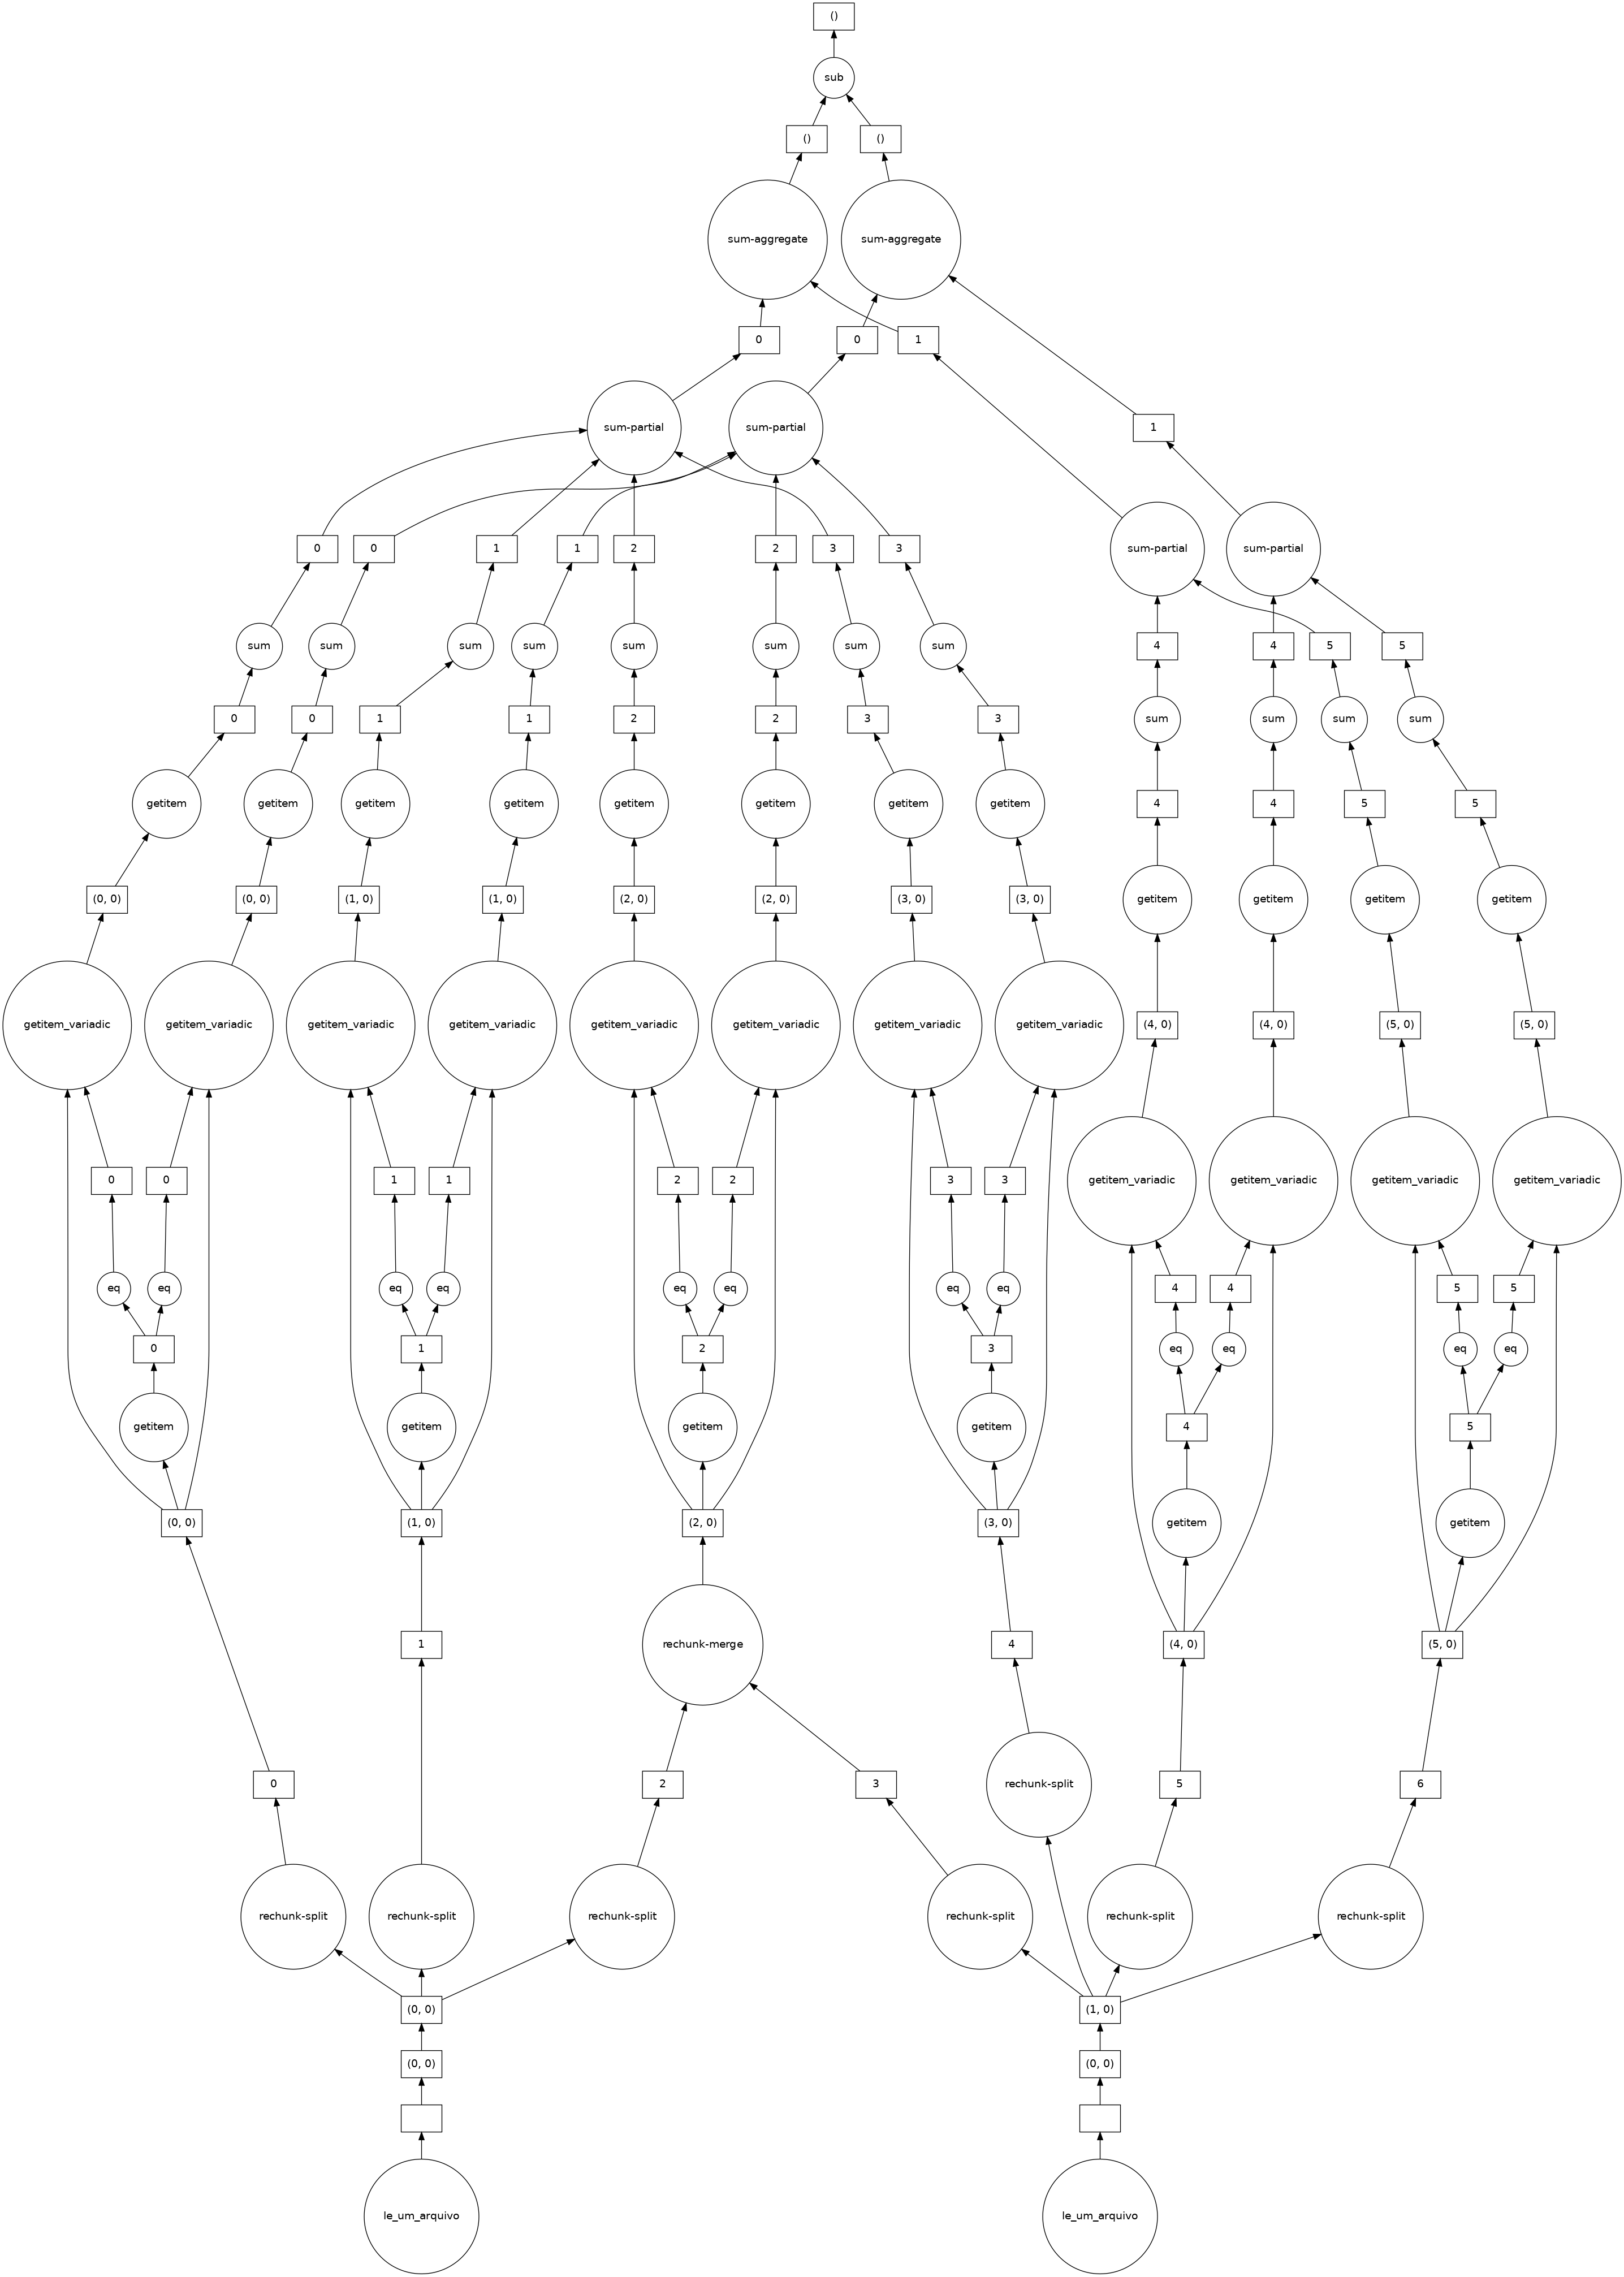

In [ ]:
importados = a[:,1] == 2
exportados = a[:,1] == 1
r = (a[exportados][:,2].sum() - a[importados][:,2].sum())
r.visualize()

In [ ]:
r.compute()

18.776825343999995